### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import itertools
# Used for mathematical functions
import math             
import logging



# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
# import pyproj
# import shapely.geometry
# from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import tqdm


# Used for making the graph to visualize our problem
# import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

# OpenTNSim
import opentnsim

# turn on debug messages if want to see what's going on in detail
# logging.basicConfig(level=logging.DEBUG)
# turn off debug messages, only show info and higher level messages
logging.basicConfig(level=logging.INFO)

### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [2]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.core.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [3]:
# Create a dict with all important settings
# NB: set both "v" and "P_tot_given" to None, as they will be set later

data_vessel = {
    "env": None,
    "name": 'Vessel M9',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "type": None,
    "B": 11.45,
    "L": 135,
    "H_e": None, 
    "H_f": None, 
    "T": 2.75,
    "P_installed": 2200.0,   
    "P_tot_given": None, # kW
    "L_w": 3.0 ,
    "C_B":0.85, 
    "C_year": 1990,
    "current_year":None
}             



In [4]:
# data_vessel

### Set vessel properties and sailing conditions ( input value )

In [5]:
V_s = np.linspace(0.1, 8, 200)          # ship sailing speeds to water, (m/s)
h_0 = [10, 7.5, 5, 3.5]                 # water depths,(m)
c_year = [1970, 1980, 1990, 2000, 2010, 2020]   # engine construction years

### prepare input matrix for calculation

In [6]:
# prepare the work to be done
# create a list of all combinations
work = list(itertools.product(c_year, h_0, V_s))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"C_year": item[0], "h_0": item[1], "V_s": item[2]}
    rows.append(row)

# these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.tail()

,C_year,h_0,V_s
4795,2020,3.5,7.841206
4796,2020,3.5,7.880905
4797,2020,3.5,7.920603
4798,2020,3.5,7.960302
4799,2020,3.5,8.000000


In [7]:

results = []

for i, row in tqdm.tqdm(work_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)
    C_year = row['C_year']
    data_vessel_i = data_vessel.copy()
    data_vessel_i['C_year'] = C_year
    vessel = TransportResource(**data_vessel_i)
    
    V_s = row['V_s']
    h_0 = row['h_0']
    vessel.calculate_properties() # L is used here in the computation of L_R
    
    R_f = vessel.calculate_frictional_resistance(V_s, h_0) 
    R_f_one_k1 = vessel.calculate_viscous_resistance()
    R_APP = vessel.calculate_appendage_resistance(V_s)
    R_W = vessel.calculate_wave_resistance(V_s, h_0)
    R_res = vessel.calculate_residual_resistance(V_s, h_0)
    R_T = vessel.calculate_total_resistance(V_s, h_0)
    P_tot = vessel.calculate_total_power_required(V_s)
    vessel.emission_factors_general()
    vessel.correction_factors(V_s)
    vessel.calculate_emission_factors_total(V_s)
    Fuel_g_m = vessel.calculate_fuel_use_g_m(V_s)
    [emission_g_m_CO2,emission_g_m_PM10,emission_g_m_NOX] = vessel.calculate_emission_rates_g_m(V_s)
    
    result = {}
    result.update(row)
    result['P_installed'] = vessel.P_installed
    result['R_f_one_k1'] = R_f_one_k1
    result['R_APP'] = R_APP
    result['R_W'] = R_W
    result['R_res'] = R_res
    result['R_T'] = R_T
    result['P_tot'] = P_tot
    result['Fuel_g_km'] = Fuel_g_m * 1000
    result['emission_g_km_CO2'] = emission_g_m_CO2 * 1000
    result['emission_g_km_PM10'] = emission_g_m_PM10 * 1000
    result['emission_g_km_NOX'] = emission_g_m_NOX * 1000
    results.append(result)

4800it [00:44, 107.84it/s]


In [8]:
plot_df = pd.DataFrame(results)


# convert from meters per second to km per hour
ms_to_kmh = 3.6
plot_df['V_s_km'] = plot_df['V_s'] * ms_to_kmh

plot_df.head()

,C_year,h_0,V_s,P_installed,R_f_one_k1,R_APP,R_W,R_res,R_T,P_tot,Fuel_g_km,emission_g_km_CO2,emission_g_km_PM10,emission_g_km_NOX,V_s_km
0,1970.0,10.0,0.100000,2200.0,0.034195,0.003647,2.338200e-88,0.012007,0.049849,110.008794,89763.890386,288772.345241,447.357222,6039.353504,0.360000
1,1970.0,10.0,0.139698,2200.0,0.062944,0.006714,1.351710e-64,0.023392,0.093049,110.022931,64263.439925,206736.853544,320.258018,4323.541119,0.502915
2,1970.0,10.0,0.179397,2200.0,0.099453,0.010608,5.948859e-51,0.038507,0.148568,110.047018,50053.283455,161022.477839,249.425060,3367.330738,0.645829
3,1970.0,10.0,0.219095,2200.0,0.143433,0.015299,4.713176e-42,0.057335,0.216066,110.083511,40997.151409,131888.708362,204.276293,2757.864410,0.788744
4,1970.0,10.0,0.258794,2200.0,0.194666,0.020764,9.051534e-36,0.079854,0.295284,110.134808,34723.923329,111707.600155,172.994502,2335.609618,0.931658


### Run OpenTNSim to Calculate resistance, required power and emissions 
Now we can define the run. First, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the above route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

### Figures output

### Figure 3: Components of the total resistance

In [9]:
# V_s    = np.linspace(0.1, 8, 200)
# V_s_km = V_s * 3.6
# len(V_s_km)

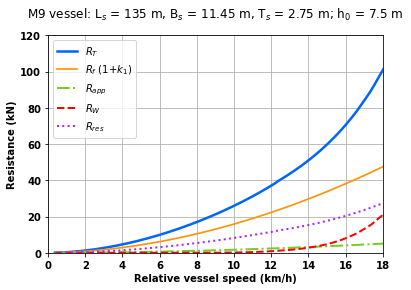

In [10]:
# resistance for water depth h_0 = 7.5 m, 1990
selected = plot_df.query('C_year == 1990 and h_0 == 7.5')

plt.figure(figsize=(6,4))
plt.plot(selected['V_s_km'], selected['R_T'], color='#0165fc', linewidth = 2.5)       # RT, total resistance of the ship,[kN] 
plt.plot(selected['V_s_km'], selected['R_f_one_k1'],color='#ff9408', linewidth = 1.7) # Rf(1+k1), frictional resistance including the hull form factor
plt.plot(selected['V_s_km'], selected['R_APP'],'-.', color='#76cd26',linewidth = 2)   # Rapp, appendage resistance
plt.plot(selected['V_s_km'], selected['R_W'], 'r--', linewidth = 2)                   # Rw, wave resistance
plt.plot(selected['V_s_km'], selected['R_res'],':',color='#aa23ff', linewidth = 2) # Rres, residual resistance
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 120)
plt.legend(['$R_T$', '$R_f$$\ $(1+$k_1$)', '$R_{app}$', '$R_W$','$R_{res}$'])
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Resistance (kN)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')

plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m; h$_0$ = 7.5 m',y=1.05)
plt.savefig('Fig_03.pdf', dpi=600, format='pdf') 
#plt.savefig('PartIV-05-04.eps', dpi=600, format='eps') 


### Figure 5: Total required power

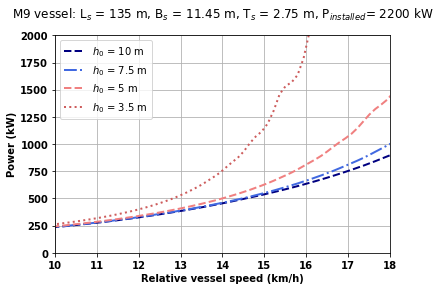

In [11]:

plt.figure(figsize = (6,4))
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='navy',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'-.', color='royalblue',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='lightcoral',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],':', color='indianred',linewidth = 2.0)

plt.grid()
plt.xlim(10, 18)
plt.ylim(0, 2000)
plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'])

plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Power (kW)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, P$_{installed}$= 2200 kW' ,y=1.05)
plt.savefig('Fig_05.pdf', dpi=600, format='pdf') 


### Figure 7: validation_total power required versus speed with diff water depths (add DST results to Fig.5)

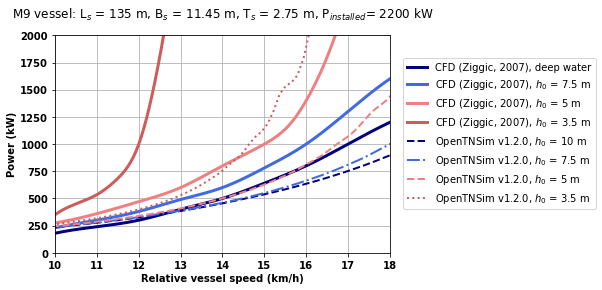

In [12]:
from scipy.interpolate import make_interp_spline, BSpline

plt.figure(figsize = (6,4))
V_DST_1=np.array([10,11,12,13,14,15,16,17,18]) # deep water
P_DST_1=np.array([180,240,300,400,500,640,800,1000,1200])
V_DST_2=np.array([10,11,12,13,14,15,16,17,18]) # h=7.5 m
P_DST_2=np.array([230,300,380,490,600,780,1000,1300,1600])
V_DST_3=np.array([10,11,12,13,14,15,15.65,16,16.5,16.7]) # h=5 m
P_DST_3=np.array([275,360,470,600,800,1000,1200,1400,1800,2005])
V_DST_4=np.array([10,10.5,11,11.5,12,12.5,13]) # h=3.5 m
P_DST_4=np.array([350,450,535,685,1000,1800,3000])
#define spline, make the lines smooth
V_DST_1_new = np.linspace(V_DST_1.min(), V_DST_1.max(), 200) 
V_DST_2_new = np.linspace(V_DST_2.min(), V_DST_2.max(), 200) 
V_DST_3_new = np.linspace(V_DST_3.min(), V_DST_3.max(), 200) 
V_DST_4_new = np.linspace(V_DST_4.min(), V_DST_4.max(), 200) 

spl1= make_interp_spline(V_DST_1,P_DST_1, k=3)
P_DST_1_new = spl1(V_DST_1_new)
spl2= make_interp_spline(V_DST_2,P_DST_2, k=3)
P_DST_2_new = spl2(V_DST_2_new)
spl3= make_interp_spline(V_DST_3,P_DST_3, k=3)
P_DST_3_new = spl3(V_DST_3_new)
spl4= make_interp_spline(V_DST_4,P_DST_4, k=3)
P_DST_4_new = spl4(V_DST_4_new)
                 
plt.plot(V_DST_1_new,P_DST_1_new,color='navy',linewidth = 3.0)
plt.plot(V_DST_2_new,P_DST_2_new,color='royalblue',linewidth = 3.0)
plt.plot(V_DST_3_new,P_DST_3_new,color='lightcoral',linewidth = 3.0)
plt.plot(V_DST_4_new,P_DST_4_new,color='indianred',linewidth = 3.0)

# selected = plot_df.query('c_year == 1990 and h_0 == 150 and P_tot < P_installed')
# plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='red',linewidth = 2.0)
# selected = plot_df.query('c_year == 1990 and h_0 == 50 and P_tot < P_installed')
# plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='orange',linewidth = 2.0)
# selected = plot_df.query('c_year == 1990 and h_0 == 20 and P_tot < P_installed')
# plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='yellow',linewidth = 2.0)

selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='navy',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'-.', color='royalblue',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='lightcoral',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],':', color='indianred',linewidth = 2.0)
plt.grid()
plt.xlim(10, 18)
plt.ylim(0, 2000)
plt.legend(['CFD (Ziggic, 2007), deep water', 'CFD (Ziggic, 2007), $h_0$ = 7.5 m', 'CFD (Ziggic, 2007), $h_0$ = 5 m', 'CFD (Ziggic, 2007), $h_0$ = 3.5 m',
        'OpenTNSim v1.2.0, $h_0$ = 10 m', 'OpenTNSim v1.2.0, $h_0$ = 7.5 m', 'OpenTNSim v1.2.0, $h_0$ = 5 m', 'OpenTNSim v1.2.0, $h_0$ = 3.5 m'],loc=(1.04,0.2))

plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Power (kW)',fontsize=10,weight='bold',labelpad=3)
#plt.title('total power required versus speed with diff water depths (type = M9, L = 135 m, B = 11.45 m, T = 2.75 m)')
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, P$_{installed}$= 2200 kW',y=1.05)
plt.savefig('Fig_07.pdf',bbox_inches = 'tight',dpi=600, format='pdf') 


### Figure 8: Emissions as a function of vessel speed: emission rates in g/km versus speed for different water depths

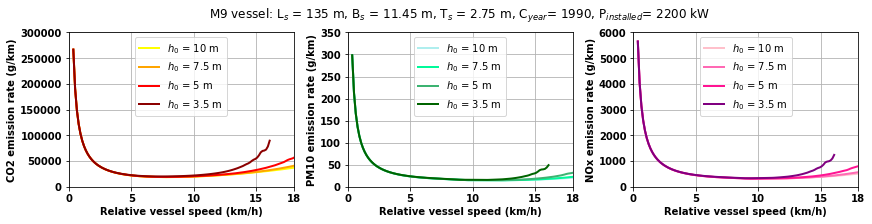

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3),constrained_layout=True)
fontsize=10


ax=plt.subplot(131)
# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'yellow',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'orange',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'red',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'darkred',linewidth = 2.0)

plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)  #  set vessel speed range (km/h) for inland shipping
plt.ylim(0, 300000)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('CO2 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')


ax=plt.subplot(132)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'paleturquoise',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'mediumspringgreen',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'mediumseagreen',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'darkgreen',linewidth = 2.0)

plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 350)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('PM10 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, C$_{year}$= 1990, P$_{installed}$= 2200 kW',y=1.05)

ax=plt.subplot(133)
# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'pink',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'hotpink',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'deeppink',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'purple',linewidth = 2.0)

plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 6000)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('NOx emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')


plt.savefig('Fig_08.pdf', dpi=600, format='pdf')  
#plt.savefig('PartIV-05-09.eps', dpi=600, format='eps') 

### Figure 9: Emissions as a function of engine age: emission rates in g/km versus speed for different engine ages


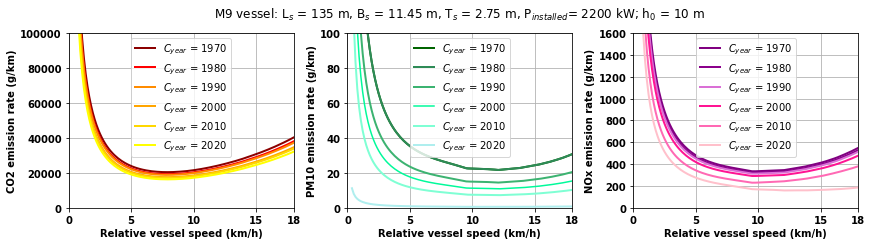

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3.3),constrained_layout=True)
fontsize=10

ax=plt.subplot(131)
# Select data for this subplot/line
selected = plot_df.query('C_year == 1970 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'darkred',linewidth = 2.0)   

selected = plot_df.query('C_year == 1980 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'red',linewidth = 2.0)      

selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'darkorange',linewidth = 2.0)

selected = plot_df.query('C_year == 2000 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'orange',linewidth = 2.0)    

selected = plot_df.query('C_year == 2010 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'gold',linewidth = 2.0)      

selected = plot_df.query('C_year == 2020 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'yellow',linewidth = 2.0)    

plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000', 
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 100000)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('CO2 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18],weight = 'bold')
plt.yticks( weight = 'bold')

ax=plt.subplot(132)
selected = plot_df.query('C_year == 1970 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'darkgreen',linewidth = 2.0)

selected = plot_df.query('C_year == 1980 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'seagreen',linewidth = 2.0)

selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'mediumseagreen',linewidth = 2.0)

selected = plot_df.query('C_year == 2000 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'mediumspringgreen')

selected = plot_df.query('C_year == 2010 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'aquamarine',linewidth = 2.0)

selected = plot_df.query('C_year == 2020 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'paleturquoise',linewidth = 2.0)

plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000', 
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 100)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('PM10 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, P$_{installed}$= 2200 kW; h$_0$ = 10 m',y=1.05)

ax=plt.subplot(133)
selected = plot_df.query('C_year == 1970 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'purple',linewidth = 2.0)

selected = plot_df.query('C_year == 1980 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'darkmagenta',linewidth = 2.0)

selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'orchid',linewidth = 2.0)

selected = plot_df.query('C_year == 2000 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'deeppink',linewidth = 2.0)

selected = plot_df.query('C_year == 2010 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'hotpink',linewidth = 2.0)

selected = plot_df.query('C_year == 2020 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'pink',linewidth = 2.0)

plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000',
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 1600)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('NOx emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')

plt.savefig('Fig_09.pdf', dpi=600, format='pdf')
#plt.savefig('PartIV-05-10.eps', dpi=600, format='eps')
#fig.suptitle('Emission rate versus velocity, for different engine ages  \n (type = M9, L = 135 m, B = 11.45 m, T = 2.75 m, h = 10 m)')